In [135]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Synthetic Circle

## Description of the Problem

This is a dataset given which has 100 circles made up of 10000 points. The data has 3 columns 'x', 'y' and 'z'. This dataset is primarly created to gauge how well do clustering algorithms perform on this task. We will begin with Exploratory Data Analysis and then proceed with Preprocessing and Analysis of results. 

In [136]:
df = pd.read_csv('circles.csv') 

In [137]:
df.head()

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


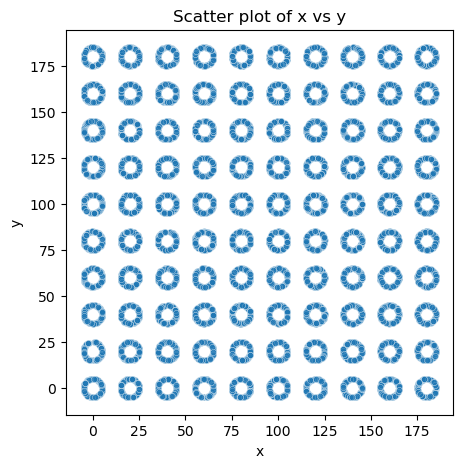

In [138]:
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='x', y='y', s=20, color='tab:blue', alpha=0.7)
plt.title('Scatter plot of x vs y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plotted graph to verify that the "dataset comprises ... points arranged into 100 circles"

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
 1   y       10000 non-null  float64
 2   class   10000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 234.5 KB


$1000$ non-null data rows. $x,y \in$ float and class $\in$ int

In [140]:
df.describe()

,x,y,class
count,10000.000000,10000.000000,10000.000000
mean,89.981670,90.003827,49.500000
std,57.457467,57.559719,28.867513
min,-5.000000,-4.999860,0.000000
25%,40.237885,40.133840,24.750000
50%,89.999995,90.000080,49.500000
75%,139.898800,139.977695,74.250000
max,184.999920,185.000000,99.000000


In [141]:
print(df.isnull().sum())
df[df.duplicated(keep=False)]

x        0
y        0
class    0
dtype: int64


,x,y,class


No null entries and no duplicate rows with duplicates

In [142]:
# #data normalization (Z-score Normalization) 
# for col in ['x','y']:
#     mean = df[col].mean()
#     std = df[col].std()
#     df[col] = (df[col] - mean) / std

Performed z-score normalization. Rationale for choosing z-score instead of min-max or other normalization techniques is prior experience with several clustering examples is Z-score preserves the data much better than other normalization techinques doesnt alter the underlying distribution too much. 

In [143]:
df.head()

,x,y,class
0,3.15676,116.12252,6
1,16.14436,16.81660,11
2,100.31212,64.99025,53
3,-1.33773,84.81772,4
4,104.37328,62.42373,53


### Dimensionality Reduction

In this section we will proceed to reduce the dimension of this to 1 as specified by the document as it wanted us to reduce dimensions so we capture x,y is captured in PC1 in z.


In [144]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
df['z'] = pca.fit_transform(df[['x','y', 'class']])
df.head()



,x,y,class,z
0,3.15676,116.12252,6,-94.202441
1,16.14436,16.81660,11,-89.820473
2,100.31212,64.99025,53,8.382456
3,-1.33773,84.81772,4,-102.058207
4,104.37328,62.42373,53,11.748846


### Kmeans Clustering Algorithm 

Let us now impliment the Kmeans Clustering method. Prelimnarily we need a function which can compute the euclidean distances very quickly. We will be using python's Numpy library to speed up a lot of operations. So we begin this by randomly sampling k centroids from a uniform distribution and then we iterate and recompute which points belong to which other cluster compared to initial clusters and keep iterating till we reach convergence or reach max iteration. Max iteration is built to prevent infinite loops. 

We impliment this in the class Kmeans, which contains all the necessery functions for the Kmeans clustering implimentation. It is also speed up by using numpy array vectorizations as matrix multiplications are quicker than forloops because they use cython. We also have one of the metrics to see quality of our clusters Silhoutte score. 

In [145]:
#Kmeans Clustering algorithm 
def euclidean_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2))

class KMeans: 
    #initialize k and max iterations (to prevent infinite loops)
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    #Main Clustering function
    def fit(self, data):


        #initalize k random centroids from a unifrom distribution
        min_c, max_c = np.min(data, axis=0), np.max(data, axis=0)
        self.centroids = [np.random.uniform(min_c, max_c) for _ in range(self.k)]
        self.centroids = np.array(self.centroids) 
         
        #iter to refine centroids
        curr_iter = 0
        prev_centroids = None
        
        pbar = tqdm(total=self.max_iter, desc="Clustering Progress")
        while (prev_centroids is None or np.not_equal(prev_centroids, self.centroids).any()) and curr_iter < self.max_iter:

            #calccculate all squared distances from N points to K centroids
            diff = data[:, np.newaxis] - self.centroids
            sqr_dists = np.sum(diff**2, axis=2)
            
            #assign each point to the closest centroid
            labels = np.argmin(sqr_dists, axis=1)
            prev_centroids = np.copy(self.centroids)
            
            for i in range(self.k):
                clustered_pts = data[labels == i]
                if len(clustered_pts) > 0:
                    self.centroids[i] = np.mean(clustered_pts, axis=0)
                else:
                    self.centroids[i] = prev_centroids[i]

            curr_iter += 1
            pbar.update(1)
        pbar.close()

class Eval: 
    @staticmethod
    def silhouette_score(data, labels):
        labels = np.array(labels)
        silhouette_scores = []
        unique_labels = np.unique(labels)
        
        for i, point in tqdm(enumerate(data), total=len(data), desc="Silhouette Score Progress"):
            #points in same cluster
            same_cluster_mask = labels == labels[i]
            same_clustered_pts = data[same_cluster_mask]
            
            #calculate intracluster distance a
            if len(same_clustered_pts) > 1:
                a = np.mean([euclidean_distance(point, p) for p in same_clustered_pts if not np.array_equal(p, point)])
            else:
                a = 0
            
            #calculate intercluster distance b
            b = np.inf
            for cluster_label in unique_labels:
                if cluster_label != labels[i]:
                    other_cluster_mask = labels == cluster_label
                    other_clustered_pts = data[other_cluster_mask]
                    if len(other_clustered_pts) > 0:
                        mean_dist = np.mean([euclidean_distance(point, p) for p in other_clustered_pts])
                        b = min(b, mean_dist)
            
            #calculate silhouette score for this point
            if max(a, b) > 0:
                silhouette_scores.append((b - a) / max(a, b))
            else:
                silhouette_scores.append(0)
        
        return np.mean(silhouette_scores)

In [174]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

X = df[['z']].values 
kmeans = KMeans(k=100, max_iter=200)
kmeans.fit(X)
# assign points to nearest centroids
distances = np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2)
labels_sk = np.argmin(distances, axis=1)

db = DBSCAN(eps=0.09, min_samples=3)
labels_db = db.fit_predict(X)

n_noise = int((labels_db == -1).sum())
unique_labels = set(labels_db)
n_clusters = len(unique_labels - {-1})

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points")

# compute silhouette score excluding noise points
mask = labels_db != -1
if n_clusters >= 2 and mask.sum() > 0:
    S_db = silhouette_score(X[mask], labels_db[mask])
    print(f"DBSCAN Silhouette Score (excluding noise): {S_db:.6f}")
else:
    print("Silhouette score cannot be computed: need at least 2 clusters (excluding noise).")

# compute sklearn silhouette score
S_sk = silhouette_score(X, labels_sk)
print(f"Sklearn Silhouette Score: {S_sk:.6f}")
# score = kmeans.silhouette_score(df[['x','y']].values)
# print(f'Silhouette Score: {score}')





Clustering Progress:  30%|███       | 61/200 [00:00<00:00, 149.60it/s]



DBSCAN found 253 clusters and 51 noise points
DBSCAN Silhouette Score (excluding noise): 0.361874
DBSCAN Silhouette Score (excluding noise): 0.361874
Sklearn Silhouette Score: 0.552116
Sklearn Silhouette Score: 0.552116


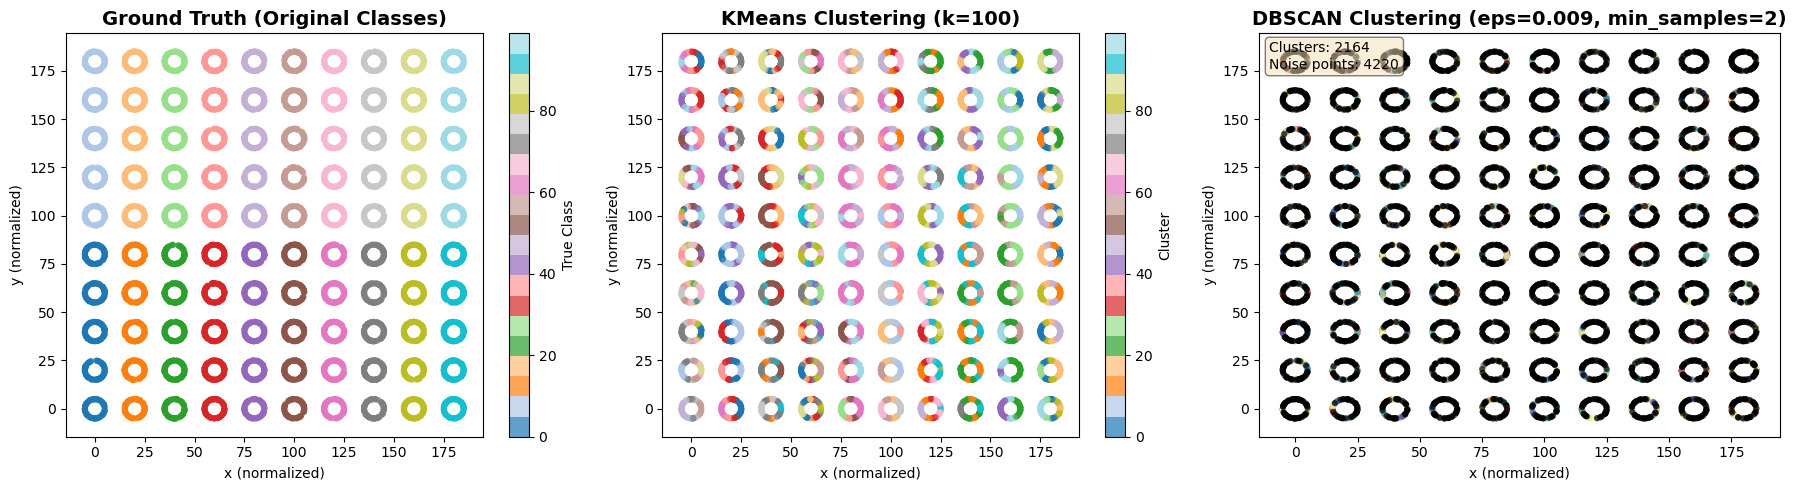


Clustering Summary:
  Ground Truth: 100 classes
  KMeans: 100 clusters
  DBSCAN: 2164 clusters + 4220 noise points


In [147]:
# Visualize clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data with true labels
ax1 = axes[0]
scatter1 = ax1.scatter(df['x'], df['y'], c=df['class'], cmap='tab20', s=20, alpha=0.7, edgecolors='none')
ax1.set_title('Ground Truth (Original Classes)', fontsize=14, fontweight='bold')
ax1.set_xlabel('x (normalized)')
ax1.set_ylabel('y (normalized)')
plt.colorbar(scatter1, ax=ax1, label='True Class')

# KMeans clustering results
ax2 = axes[1]
scatter2 = ax2.scatter(df['x'], df['y'], c=labels_sk, cmap='tab20', s=20, alpha=0.7, edgecolors='none')
ax2.set_title(f'KMeans Clustering (k={kmeans.k})', fontsize=14, fontweight='bold')
ax2.set_xlabel('x (normalized)')
ax2.set_ylabel('y (normalized)')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN clustering results
ax3 = axes[2]
# Create color map - noise points in black
unique_labels_db = set(labels_db)
colors_db = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_db))]

for k, col in zip(unique_labels_db, colors_db):
    if k == -1:
        # Black for noise
        col = [0, 0, 0, 1]
    
    class_member_mask = (labels_db == k)
    xy = df[['x', 'y']].values[class_member_mask]
    ax3.scatter(xy[:, 0], xy[:, 1], c=[col], s=20, alpha=0.7, edgecolors='none', 
                label='Noise' if k == -1 else f'Cluster {k}')

ax3.set_title(f'DBSCAN Clustering (eps={db.eps}, min_samples={db.min_samples})', 
              fontsize=14, fontweight='bold')
ax3.set_xlabel('x (normalized)')
ax3.set_ylabel('y (normalized)')

# Add summary text
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = list(labels_db).count(-1)
textstr = f'Clusters: {n_clusters_db}\nNoise points: {n_noise_db}'
ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nClustering Summary:")
print(f"  Ground Truth: {len(df['class'].unique())} classes")
print(f"  KMeans: {len(set(labels_sk))} clusters")
print(f"  DBSCAN: {n_clusters_db} clusters + {n_noise_db} noise points")

In [148]:
# Compare clustering results with true labels using NMI
from sklearn.metrics import normalized_mutual_info_score

# Get true labels from the dataset
true_labels = df['class'].values

# Get predicted labels from KMeans
distances = np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2)
predicted_labels = np.argmin(distances, axis=1)

# Calculate NMI
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.6f}")
print(f"NMI ranges from 0 (no mutual information) to 1 (perfect correlation)")
print(f"\nInterpretation:")
if nmi_score > 0.7:
    print("- Strong agreement between clustering and true labels")
elif nmi_score > 0.4:
    print("- Moderate agreement between clustering and true labels")
else:
    print("- Weak agreement between clustering and true labels")

Normalized Mutual Information (NMI): 0.671384
NMI ranges from 0 (no mutual information) to 1 (perfect correlation)

Interpretation:
- Moderate agreement between clustering and true labels


## Results (Avi take a look)

After Normalization and dim reduction: 
Kmeans gets a silhoutte score of 0.7 - 0.74 and a NMI of 0.65 basically showing it captures around 70 clusters  wheras DBscans captures 100 clusters with no noise (perfect captures) This is expected as afternormalizaiton the structure of circles gets destoryed as we are mapping x and y to a value between 0 and 1 thus the density represnetation changes while k means which expects circles fails. 

No normalization and yes dim reduction:
Kmeans as expected gets 100 percent of the 

In [149]:
# from sklearn.cluster import KMeans as SKKMeans
# from sklearn.metrics import silhouette_score
# # X = your feature array, shape (n_points, 2)
# k = 100  # same as your custom KMeans

# sk_kmeans = SKKMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
# sk_kmeans.fit(X)

# # Get cluster labels
# labels_sk = sk_kmeans.labels_
# S_sk = silhouette_score(X, labels_sk)
# print(f"Sklearn KMeans Silhouette Score: {S_sk:.4f}")

In [150]:
#DBscan Algorithm

def euclidean_distance(point, data):
    return np.sqrt(np.sum((point - data) ** 2))

def neighbours(X, point_idx, eps):
    dist = [euclidean_distance(X[point_idx], X[i]) for i in range(len(X))]
    return [i for i, d in enumerate(dist) if d <= eps]

def findpts(X, eps, min_pts):
    core_pts = []
    for i in tqdm(range(len(X))):
        if len(neighbours(X, i, eps)) >= min_pts:
            core_pts.append(i)
    return core_pts

def expand_cluster(X, labels, points_idx, neighbours_list, cluster_id, eps, min_pts):
    labels[points_idx] = cluster_id
    i = 0
    while i < len(neighbours_list):
        neigh = neighbours_list[i]
        if labels[neigh] == -1:
            labels[neigh] = cluster_id
        elif labels[neigh] == 0:
            labels[neigh] = cluster_id
            new_neighbours = neighbours(X, neigh, eps)
            if len(new_neighbours) >= min_pts:
                neighbours_list.extend(new_neighbours)
        i += 1
    return labels

def dbscan(X, eps, min_pts):
    labels = np.zeros(len(X))
    cluster_id = 0
    core_pts = findpts(X, eps, min_pts)
    
    for point_idx in tqdm(range(len(X)), desc="DBSCAN clustering"):
        if labels[point_idx] != 0:
            continue
        if point_idx in core_pts:
            cluster_id += 1
            new_neighbours = neighbours(X, point_idx, eps)
            labels = expand_cluster(X, labels, point_idx, new_neighbours, cluster_id, eps, min_pts)
        else:
            labels[point_idx] = -1 
    return labels



# Bank Marketing

## About the Dataset

The dataset is captured by a Portuguese banking institution for the purpose of improving their direct marketing campaign. The classification goal is to predict if the client will subscribe to a term deposit.

The about section of the dataset provides other key insights that guides our data exploration and pre-processing. The datasets we have considered (as per the question) is the one with 17 features split into a complete csv dataset with all the data points (total 45211) and another csv dataset with a 10% randomly selected sample.

The data-types are either Categorical or Integer. The categorical data-types will need to be encoded with one-hot encoding. The about section also mentions that some features have missing values which means they will either need to be dropped or we need to impute the value.

In [151]:
# Load the bank marketing dataset properly
import re

def parse_bank_csv_line(line):
    # Remove outer quotes and split by semicolon, then clean inner quotes
    line = line.strip().strip('"')  
    parts = line.split(';')
    cleaned_parts = []
    for part in parts:
        # Remove double quotes around values
        part = part.strip('""')
        cleaned_parts.append(part)
    return cleaned_parts

# Read and parse the file
data = []
with open('bank_marketing/bank-full.csv', 'r', encoding='utf-8') as f:
    for line in f:
        parsed_line = parse_bank_csv_line(line.strip())
        data.append(parsed_line)

# Create DataFrame
columns = data[0]  # First row is header
df_bank = pd.DataFrame(data[1:], columns=columns)

In [152]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [153]:
df.isnull().sum().sum()

0

In [154]:
# how many occurances of "unknown" in entire df_bank
total_unknowns = sum((df_bank[col] == "unknown").sum() for col in df_bank.columns)
total_unknowns

52124

In [155]:
# converting integer columns to int
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Convert columns to integers
for col in integer_columns:
    if col in df_bank.columns:
        df_bank[col] = pd.to_numeric(df_bank[col], errors='coerce').astype('Int64')  # Use Int64 to handle NaN values

df.dtypes

x        float64
y        float64
class      int64
z        float64
dtype: object

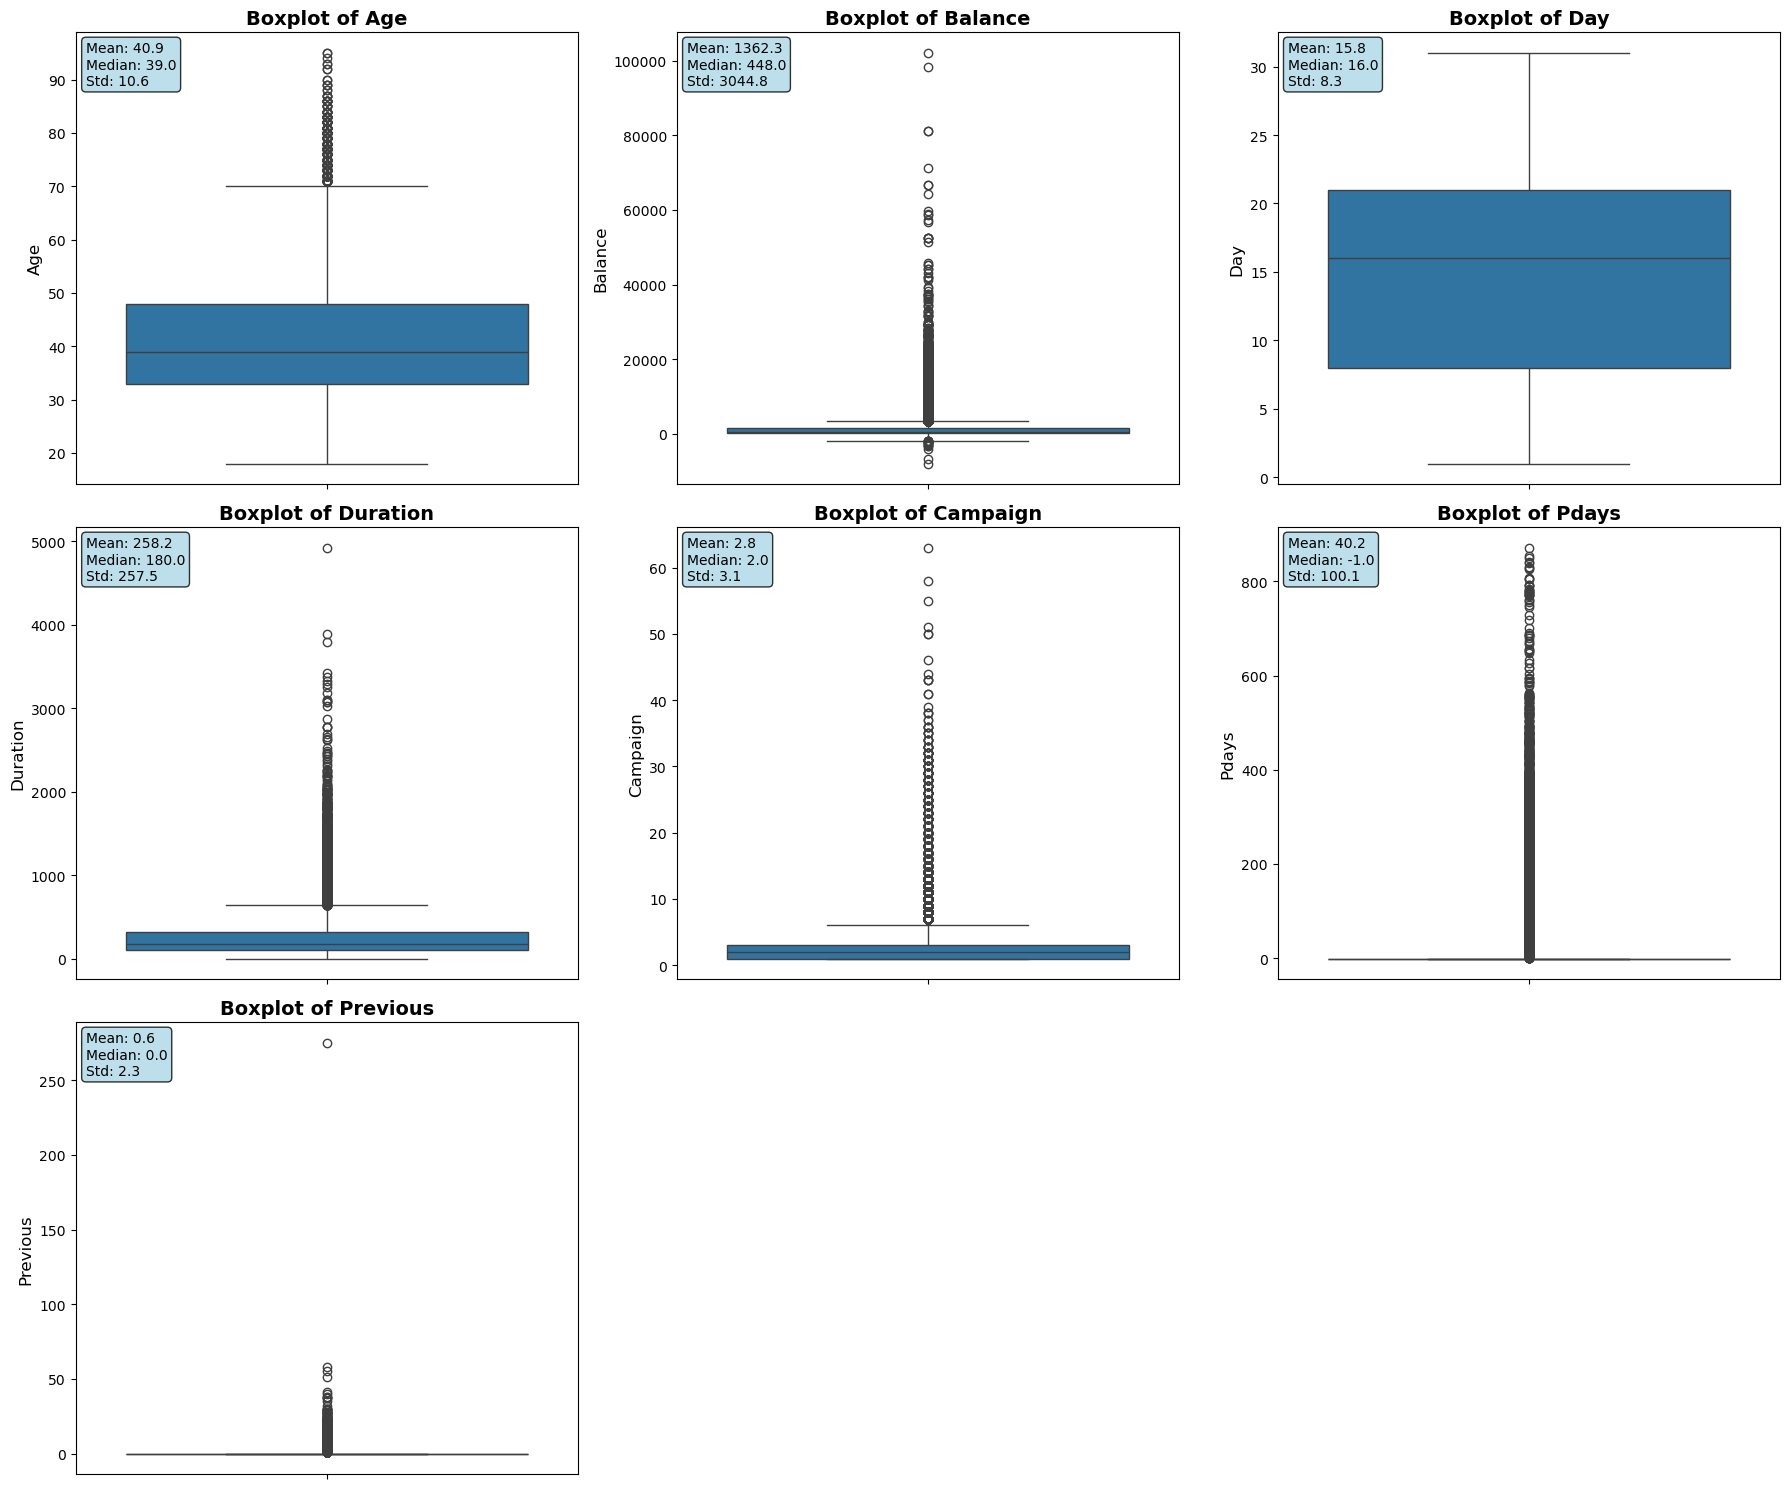

In [156]:
# Create a subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(integer_columns):
    if i < len(axes):
        sns.boxplot(data=df_bank, y=col, ax=axes[i])
        axes[i].set_title(f'Boxplot of {col.title()}', fontsize=14, fontweight='bold')
        axes[i].set_ylabel(col.title(), fontsize=12)
        
        # Add statistics text
        mean_val = df_bank[col].mean()
        median_val = df_bank[col].median()
        std_val = df_bank[col].std()
        
        stats_text = f'Mean: {mean_val:.1f}\nMedian: {median_val:.1f}\nStd: {std_val:.1f}'
        axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Hide unused subplots
for j in range(len(integer_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

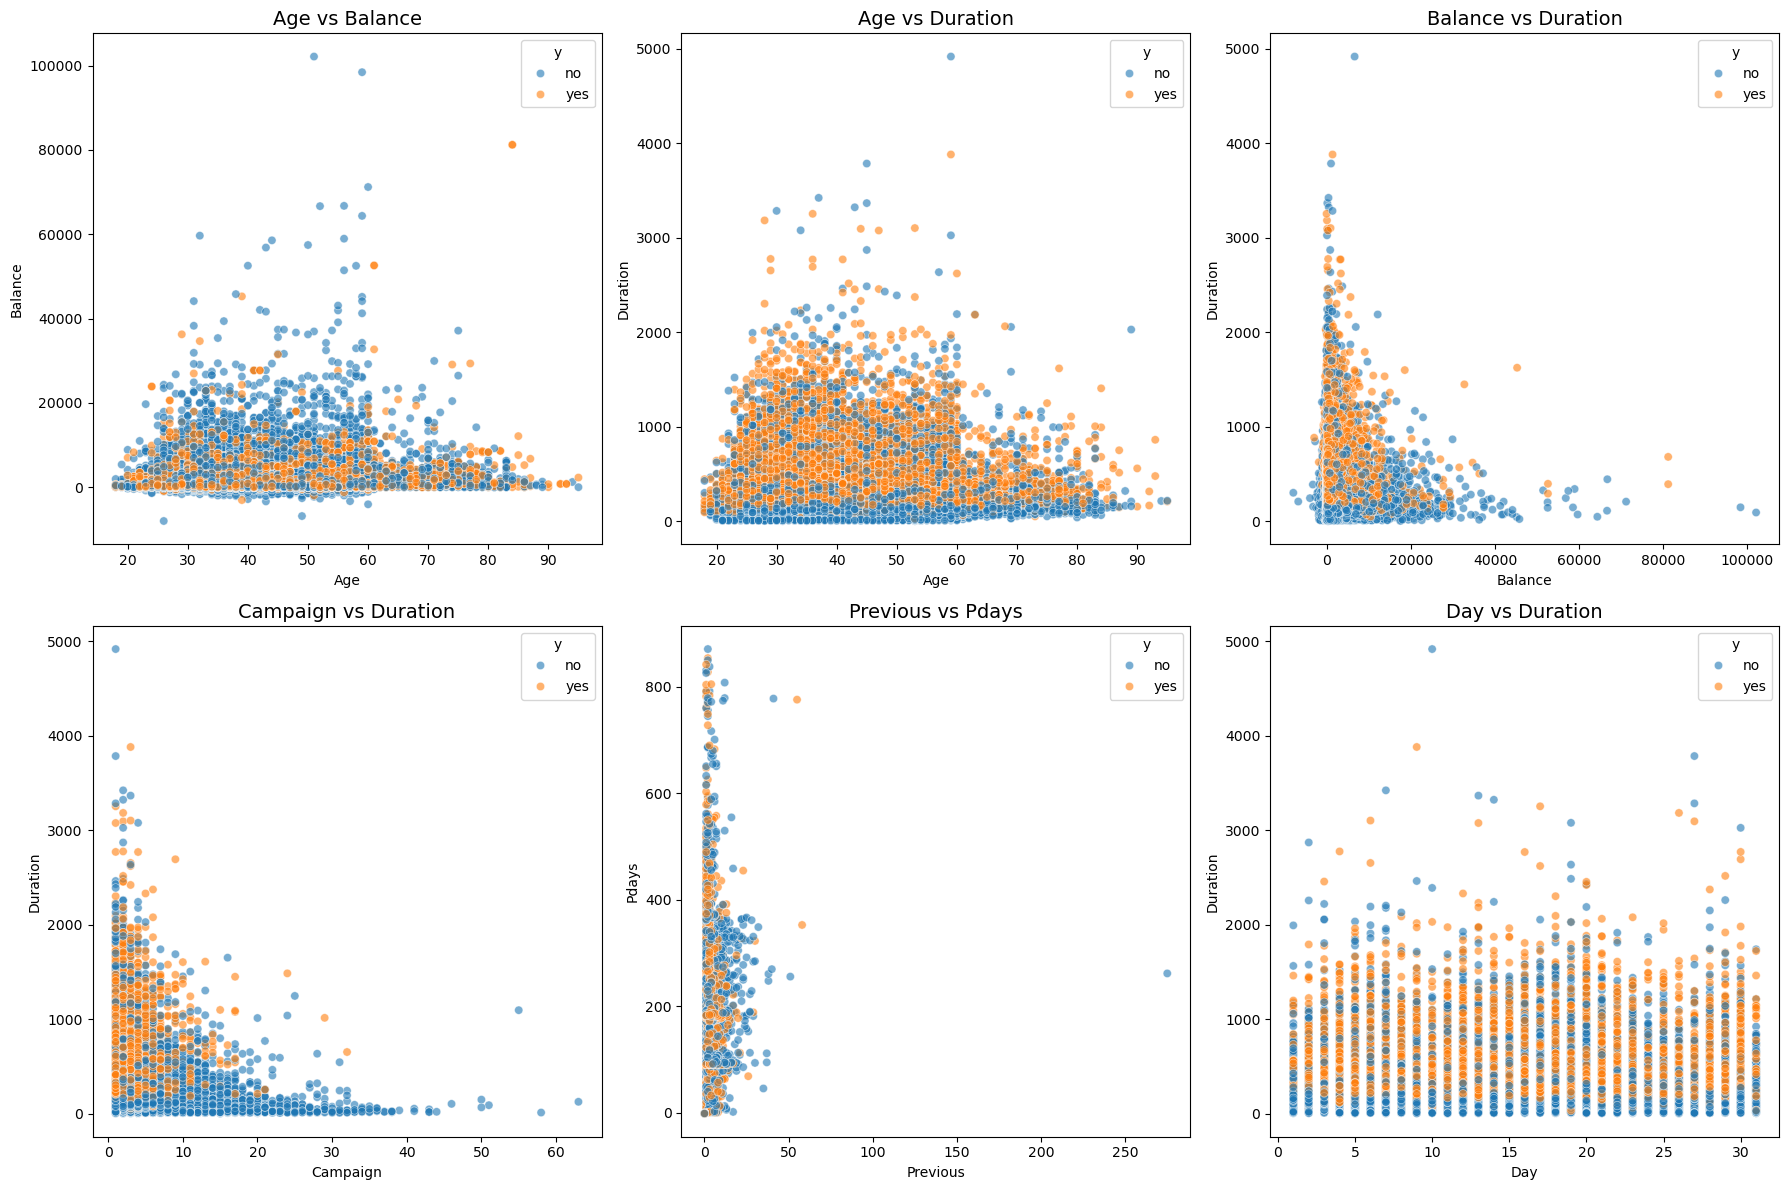

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [157]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [158]:
#Outlier remover
# def whisker(col):
#     Q1,Q3 = np.percentile(col,[25,75])
#     iqr = Q3 - Q1
#     lw = Q1 - (1.5 * iqr)
#     uw = Q3 + (1.5 * iqr)
#     return lw, uw

# for col in integer_columns:
#     lw, uw = whisker(df_bank[col])
#     df_bank = df_bank[(df_bank[col] >= lw) & (df_bank[col] <= uw)]

In [159]:
# Z-score Normalization for integer columns
for col in integer_columns:
    mean = df_bank[col].mean()
    std = df_bank[col].std()
    df_bank[col] = (df_bank[col] - mean) / std

df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1.606947,management,married,tertiary,no,0.256416,yes,no,unknown,-1.298462,may,0.011016,-0.569344,-0.411449,-0.251938,unknown,no
1,0.288526,technician,single,secondary,no,-0.43789,yes,no,unknown,-1.298462,may,-0.416122,-0.569344,-0.411449,-0.251938,unknown,no
2,-0.747376,entrepreneur,married,secondary,no,-0.446758,yes,yes,unknown,-1.298462,may,-0.707353,-0.569344,-0.411449,-0.251938,unknown,no
3,0.571045,blue-collar,married,unknown,no,0.047205,yes,no,unknown,-1.298462,may,-0.645224,-0.569344,-0.411449,-0.251938,unknown,no
4,-0.747376,unknown,single,unknown,no,-0.447086,no,no,unknown,-1.298462,may,-0.233618,-0.569344,-0.411449,-0.251938,unknown,no


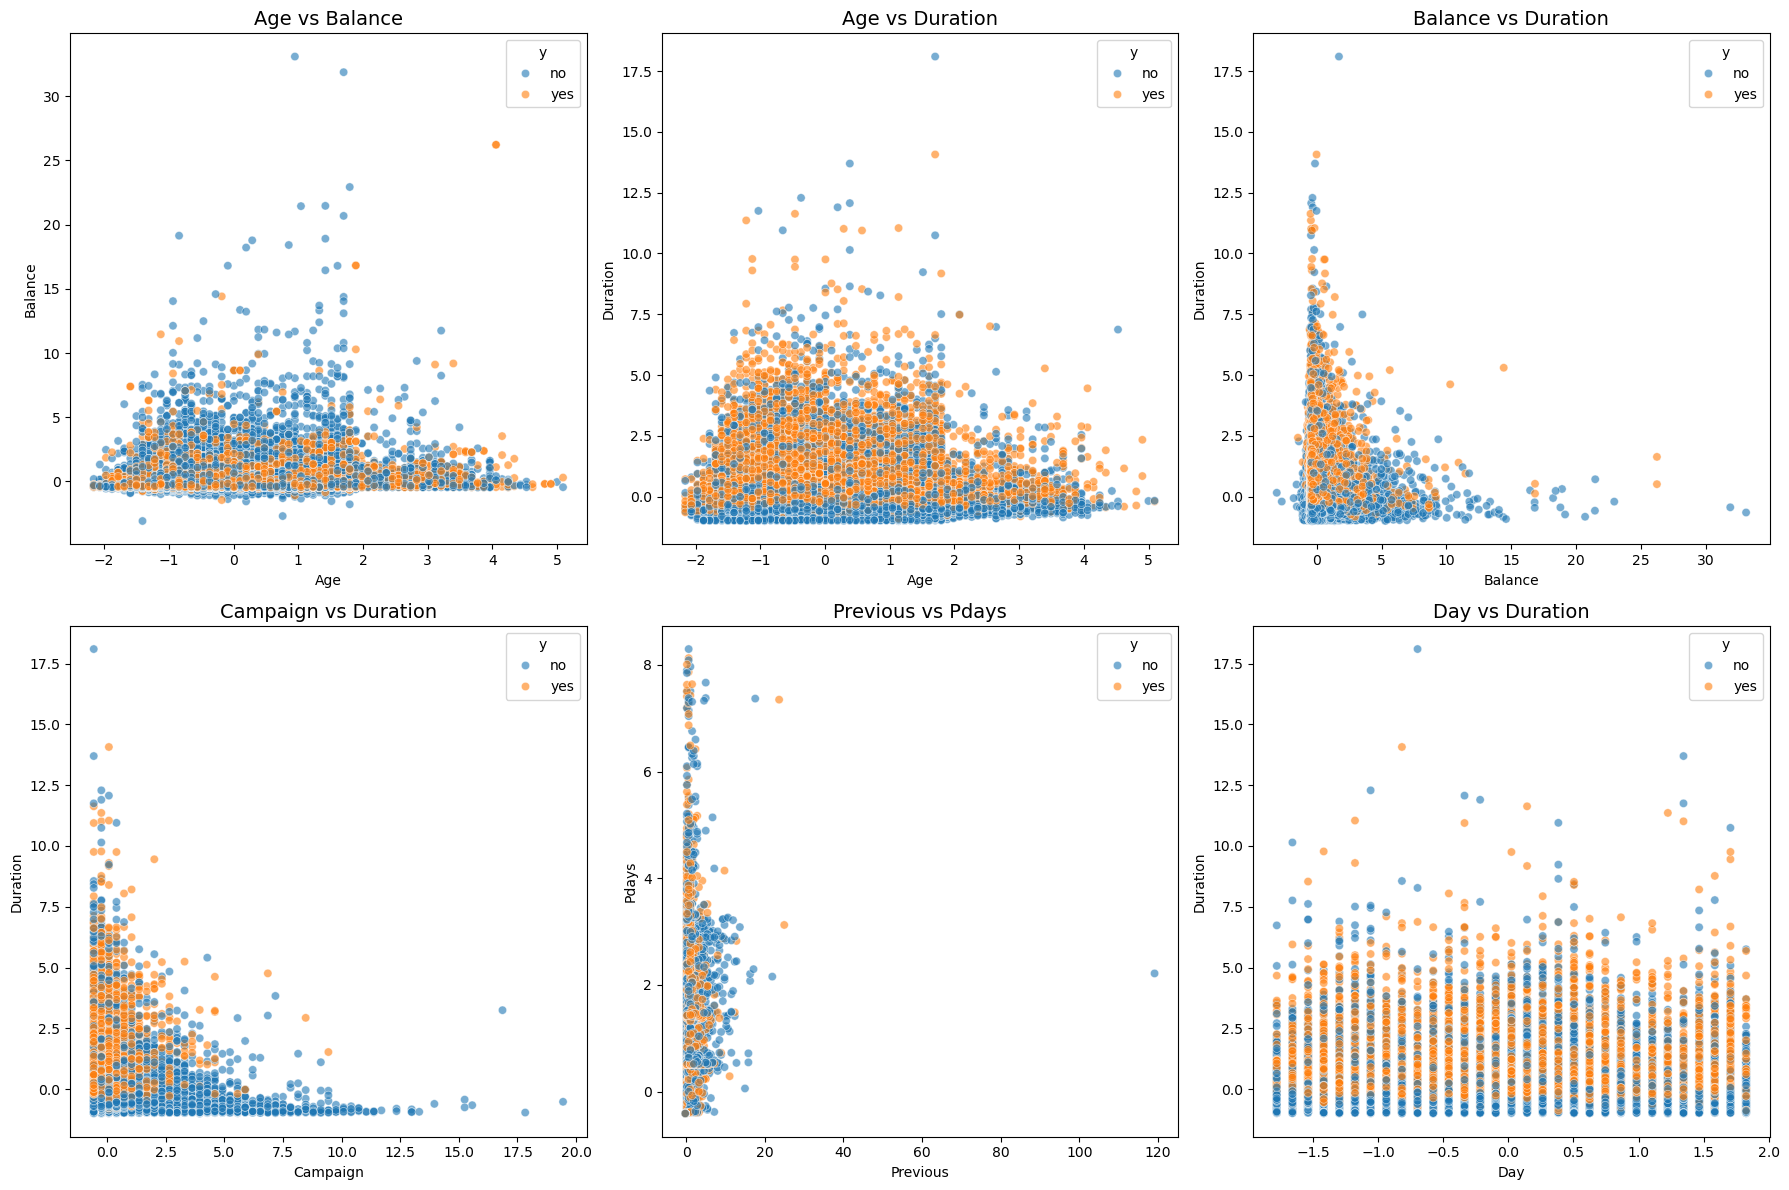

Scatter plots showing relationships between numeric variables.
Points are colored by subscription outcome (y): 'yes' vs 'no'


In [160]:
# Create scatter plots to explore relationships between numeric variables
integer_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create scatter plots for interesting relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Define interesting relationships to plot
relationships = [
    ('age', 'balance'),
    ('age', 'duration'),
    ('balance', 'duration'),
    ('campaign', 'duration'),
    ('previous', 'pdays'),
    ('day', 'duration')
]

for i, (x_col, y_col) in enumerate(relationships):
    if i < len(axes):
        # Color by target variable 'y' if you want to see subscription patterns
        sns.scatterplot(data=df_bank, x=x_col, y=y_col, hue='y', ax=axes[i], alpha=0.6)
        axes[i].set_title(f'{x_col.title()} vs {y_col.title()}', fontsize=14)
        axes[i].set_xlabel(x_col.title())
        axes[i].set_ylabel(y_col.title())

plt.tight_layout()
plt.show()

print("Scatter plots showing relationships between numeric variables.")
print("Points are colored by subscription outcome (y): 'yes' vs 'no'")

In [161]:
replacements = {'yes': '1', 'no': '0'}
df_bank['y'] = df_bank['y'].replace(replacements)
df['y'] = df_bank['y'].astype(int)

In [162]:
categorical_columns = df_bank.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')  # Exclude target variable
df_bank = pd.get_dummies(df_bank, columns=categorical_columns, drop_first=True, dtype=int)
df_bank.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.606947,0.256416,-1.298462,0.011016,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.288526,-0.43789,-1.298462,-0.416122,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,-0.747376,-0.446758,-1.298462,-0.707353,-0.569344,-0.411449,-0.251938,0,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0.571045,0.047205,-1.298462,-0.645224,-0.569344,-0.411449,-0.251938,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,-0.747376,-0.447086,-1.298462,-0.233618,-0.569344,-0.411449,-0.251938,0,0,0,...,0,0,0,1,0,0,0,0,0,1
